<a href="https://colab.research.google.com/github/chillaks/CSE-534-Project/blob/main/fcn_ids_features_extra_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from sklearn import preprocessing
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.stats import ttest_ind
from pandas.plotting import lag_plot, autocorrelation_plot
from sklearn.metrics import make_scorer
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer 
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASETS_DIR = '/content/drive/My Drive/FCN/Project/datasets'
PLOTS_DIR = '/content/drive/My Drive/FCN/Project/plots'

In [ ]:
%cd '/content/drive/My Drive/FCN/Project/datasets' 

/content/drive/My Drive/FCN/Project/datasets


# **Data Preprocessing**

---



In [ ]:
# Import the Train and Test Datasets. Additional information on all features/labels can be found at https://docs.google.com/spreadsheets/d/1oAx320Vo9Z6HrBrL6BcfLH6sh2zIk9EKCv2OlaMGmwY/edit#gid=0
train_data = pd.read_csv('KDDTrain+.txt')
test_data = pd.read_csv('KDDTest+.txt')

train_data.drop(['difficulty_level'], axis=1, inplace=True)
test_data.drop(['difficulty_level'], axis=1, inplace=True)

In [ ]:
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
discrete = ['Wrong Fragment',
'Urgent',
'Count',
'Srv Count',
'Serror Rate',
'Srv Serror Rate',
'Rerror Rate',
'Srv Rerror Rate',
'Same Srv Rate',
'Diff Srv Rate',
'Srv Diff Host Rate',
'Dst Host Count',
'Dst Host Srv Count',
'Dst Host Same Srv Rate',
'Dst Host Diff Srv Rate',
'Dst Host Same Src Port Rate',
'Dst Host Srv Diff Host Rate',
'Dst Host Serror Rate',
'Dst Host Srv Serror Rate',
'Dst Host Rerror Rate',
'Dst Host Srv Rerror Rate',
'Su Attempted']

discrete = [ '_'.join(col.lower().split()) for col in discrete ]


In [ ]:
continuous = ['Duration',
'Src Bytes',
'Dst Bytes',
'Hot',
'Num Failed Logins',
'Num Compromised',
'Num Root',
'Num File Creations',
'Num Shells',
'Num Access Files',
'Num Outbound Cmds']

continuous = [ '_'.join(col.lower().split()) for col in continuous ]


In [ ]:
dropping_nulls =  train_data[continuous + discrete].columns[train_data[continuous + discrete].describe(percentiles=[0.8]).loc['80%'] == 0].to_list()

In [ ]:
train_data.drop(columns=dropping_nulls, inplace= True)

In [ ]:
continuous = [ x for x in continuous if x not in dropping_nulls ]
discrete = [ x for x in discrete if x not in dropping_nulls ]

In [ ]:
from sklearn.feature_selection import f_classif, SelectKBest, chi2

In [ ]:
discrete

['count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate']

In [ ]:
f_classif(train_data[continuous+discrete], train_data['label'])

(array([8.91948878e+00, 5.00634230e+00, 7.37936318e+03, 5.97905231e+03,
        1.57859899e+04, 1.59564520e+04, 4.02329202e+04, 3.19735544e+03,
        2.13717004e+03, 3.26437211e+03, 7.91189053e+03, 1.14369015e+04,
        4.49942779e+03, 5.40108490e+03, 9.84731319e+03, 1.60884601e+04,
        1.67159801e+04]),
 array([6.60614262e-30, 1.05902853e-13, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]))

In [ ]:
fs = SelectKBest(score_func=f_classif, k=8)

In [ ]:
train_selected = fs.fit_transform(train_data[discrete], train_data['label'])
train_selected.shape

(125973, 8)

In [ ]:
train_selected

array([[0.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.08, ..., 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.05, ..., 0.  , 1.  , 1.  ],
       ...,
       [0.  , 0.  , 1.  , ..., 0.  , 0.72, 0.  ],
       [1.  , 1.  , 0.06, ..., 0.  , 1.  , 1.  ],
       [0.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ]])

In [ ]:
pd.Series(fs.scores_, index=discrete).sort_values(ascending = False)

same_srv_rate                  40232.920225
dst_host_srv_serror_rate       16715.980137
dst_host_serror_rate           16088.460097
srv_serror_rate                15956.452007
serror_rate                    15785.989942
dst_host_same_srv_rate         11436.901521
dst_host_srv_diff_host_rate     9847.313194
dst_host_srv_count              7911.890531
count                           7379.363178
srv_count                       5979.052315
dst_host_same_src_port_rate     5401.084902
dst_host_diff_srv_rate          4499.427790
dst_host_count                  3264.372113
diff_srv_rate                   3197.355436
srv_diff_host_rate              2137.170039
dtype: float64

In [ ]:
top_discrete =  pd.Series(fs.scores_, index=discrete).sort_values(ascending = False).index.to_list()[:10]
top_discrete

['same_srv_rate',
 'dst_host_srv_serror_rate',
 'dst_host_serror_rate',
 'srv_serror_rate',
 'serror_rate',
 'dst_host_same_srv_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_srv_count',
 'count',
 'srv_count']

In [ ]:
continuous

['src_bytes', 'dst_bytes']

In [ ]:
top_15_service = train_data.service.value_counts().index.to_list()[:15]

In [ ]:
train_data[train_data['service'].isin(top_15_service)].shape

(106634, 26)

In [ ]:
train_data

,protocol_type,service,flag,src_bytes,dst_bytes,land,logged_in,root_shell,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,label
0,tcp,ftp_data,SF,491,0,0,0,0,0,0,2,2,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,normal
1,udp,other,SF,146,0,0,0,0,0,0,13,1,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,normal
2,tcp,private,S0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,neptune
3,tcp,http,SF,232,8153,0,1,0,0,0,5,5,0.2,0.2,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,normal
4,tcp,http,SF,199,420,0,1,0,0,0,30,32,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,tcp,private,S0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,neptune
125969,udp,private,SF,105,145,0,0,0,0,0,2,2,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,normal
125970,tcp,smtp,SF,2231,384,0,1,0,0,0,1,1,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,normal
125971,tcp,klogin,S0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,neptune


In [ ]:
# The above attack sub-classes can be categorized into 4 main classes: DoS, Probe, R2L and U2R. 
# More details on this classification can be found at https://towardsdatascience.com/a-deeper-dive-into-the-nsl-kdd-data-set-15c753364657
def label_preprocessing(data):
  data['label'].replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop',
                              'udpstorm','worm'], 'DoS', inplace=True)
  data['label'].replace(['ipsweep','mscan','nmap','portsweep','saint','satan'], 'Probe', inplace=True)
  data['label'].replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
          'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'], 'R2L', inplace=True)
  data['label'].replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'], 'U2R',inplace=True)


label_preprocessing(train_data)
label_preprocessing(test_data)

In [ ]:
train_data = train_data[train_data['label'] != 'U2R']
test_data =test_data[test_data['label'] != 'U2R']

# **Classification:**

---






## 1.   Binary Classification

In [ ]:
binary_data = train_data.copy()
def set_binary_label(label):
  return 'normal' if label == 'normal' else 'attack'
binary_label = pd.DataFrame(train_data['label'].map(set_binary_label))
binary_data['label'] = binary_label
label_map = { 'normal' : 0, 'attack': 1}
binary_data['encoded_label'] = binary_data.label.apply(lambda x : label_map[x])

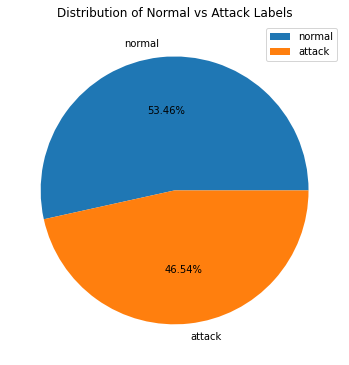

In [ ]:
# Plot the binary classification distribution
def plot_bin_label_dist(label):
  plt.figure(figsize = (6,8))
  plt.pie(label.value_counts(), labels = label.unique(), autopct='%0.2f%%')
  plt.title("Distribution of Normal vs Attack Labels")
  plt.legend()
  plt.savefig('{}/binary_labels.png'.format(PLOTS_DIR))
  plt.show()
plot_bin_label_dist(binary_data['label'])

## 2.   Multi-Class Classification

In [ ]:
# We then perform multi-class classification, where we bin the sample set into all possible unique values 
# of the label attribute, i.e, normal, DoS, Probe, R2L and U2R
# Create a clone of original dataset with multi labels
multi_data = train_data.copy()
# Encoding labels: 0 => DoS, 1 => Probe, 2 => R2L, 3 => normal
multi_le = preprocessing.LabelEncoder()
multi_data['encoded_label'] = pd.DataFrame(multi_data['label']).apply(multi_le.fit_transform)
test_data['encoded_label'] = multi_le.transform(test_data['label'])

In [ ]:
multi_data.groupby('label').encoded_label.mean()

label
DoS       0
Probe     1
R2L       2
normal    3
Name: encoded_label, dtype: int64

In [ ]:
test_data.groupby('label').encoded_label.mean()

label
DoS       0
Probe     1
R2L       2
normal    3
Name: encoded_label, dtype: int64

In [ ]:
multi_data.encoded_label.value_counts()

3    66701
0    37855
1    11290
2      993
Name: encoded_label, dtype: int64

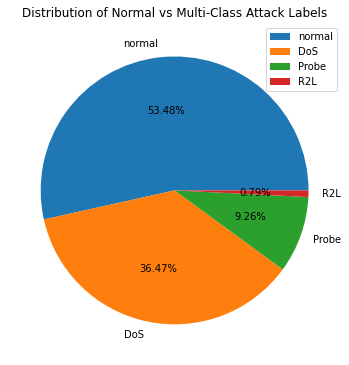

In [ ]:
# Plot the multi-class classification distribution
def plot_multi_label_dist(label):
  plt.figure(figsize = (6,8))
  plt.pie(label.value_counts(), labels = label.value_counts().index.to_list(), autopct='%0.2f%%')
  plt.title("Distribution of Normal vs Multi-Class Attack Labels")
  plt.legend()
  plt.savefig('{}/multi_labels.png'.format(PLOTS_DIR))
  plt.show()
plot_multi_label_dist(multi_data['label'])

# **Feature Selection**

---



## 1. Binary Features

In [ ]:
# Create dataframe with only numeric attributes of dataset and encoded binary labels
num_binary_data = binary_data[numeric_cols].join(binary_data['encoded_label'])
num_binary_data.head(5)

NameError: ignored

In [ ]:
# Compute correlation matrix and keep only feature attributes with correlation greater than 0.5 
# with the encoded label attribute
bin_corr_matrix = num_binary_data.corr()
bin_corr_y = abs(bin_corr_matrix['encoded_label'])
bin_features = bin_corr_y.loc[bin_corr_y >= 0.5].drop('encoded_label')
bin_feature_list = bin_features.index.to_list()
bin_feature_list

NameError: ignored

In [ ]:
# One-hot encoding the binary label
binary_data

# **Binary Machine Learning Models**

---



In [ ]:
binary_data[bin_feature_list + categorical_cols + ['encoded_label']]

,logged_in,count,serror_rate,srv_serror_rate,same_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,protocol_type,service,flag,encoded_label
0,0,2,0.0,0.0,1.00,25,0.17,0.00,0.00,tcp,ftp_data,SF,0
1,0,13,0.0,0.0,0.08,1,0.00,0.00,0.00,udp,other,SF,0
2,0,123,1.0,1.0,0.05,26,0.10,1.00,1.00,tcp,private,S0,1
3,1,5,0.2,0.2,1.00,255,1.00,0.03,0.01,tcp,http,SF,0
4,1,30,0.0,0.0,1.00,255,1.00,0.00,0.00,tcp,http,SF,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,1,1,0.0,0.0,1.00,141,0.72,0.01,0.00,tcp,smtp,SF,0
148513,1,2,0.0,0.0,1.00,255,1.00,0.01,0.00,tcp,http,SF,0
148514,1,5,0.0,0.0,1.00,255,1.00,0.00,0.00,tcp,http,SF,1
148515,0,4,0.0,0.0,1.00,252,0.99,0.00,0.00,udp,domain_u,SF,0


In [ ]:
numerical_cols = bin_feature_list

categorical_cols = categorical_cols

my_cols = numerical_cols + categorical_cols 

X_train = binary_data[binary_data['source'] == 'train'][my_cols]
X_test = binary_data[binary_data['source'] == 'test'][my_cols]
Y_train = binary_data[binary_data['source'] == 'train']['encoded_label'] # target attribute
Y_test = binary_data[binary_data['source'] == 'test']['encoded_label']



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Bundle preprocessing for numerical and categorical data

preprocessor = ColumnTransformer(
    transformers=[
        ('num' , numerical_transformer , numerical_cols ),
        ('cat', OneHotEncoder(sparse=False), categorical_cols)
    ], 
    remainder = 'passthrough')

In [ ]:
model = LogisticRegression()

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['logged_in', 'count',
                                                   'serror_rate',
                                                   'srv_serror_rate',
                                                   'same_srv_rate',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_serror_rate',
                                                   'dst_host_srv_serror_rate']),
                                                 ('cat',
                                               

In [ ]:
preds = lin_clf.predict(X_test)
accuracy_score(Y_test, preds)

0.7501774308019872

## 1. Linear Support Vector Machine Classifier (Binary Classification)

In [ ]:
X_train = binary_data[binary_data['source'] == 'train'].drop(columns = ['label', 'encoded_label', 'source'])
X_test = binary_data[binary_data['source'] == 'test'].drop(columns = ['label', 'encoded_label', 'source'])
Y_train = binary_data[binary_data['source'] == 'train']['encoded_label'] # target attribute
Y_test = binary_data[binary_data['source'] == 'test']['encoded_label'] # target attribute

0         1
1         1
2         0
3         1
4         1
         ..
125968    0
125969    1
125970    1
125971    0
125972    1
Name: encoded_label, Length: 125973, dtype: int64

In [ ]:
lsvm = svm.SVC(kernel='linear',gamma='auto') 
lsvm.fit(X_train, Y_train) # training model on training dataset
y_pred = lsvm.predict(X_test)
accuracy_score(y_pred, Y_test)

# Multiclass


In [ ]:
numerical_cols = multi_data.select_dtypes(include='number').columns.to_list()


In [ ]:
multi_corr = multi_data[numeric_col].corr().encoded_label
numerical_cols =  multi_corr[(multi_corr > 0.5) | (multi_corr < -0.5)].index.to_list()

In [ ]:
numerical_cols

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'encoded_label']

In [ ]:
numerical_cols = numerical_cols[:-1]
numerical_cols

['src_bytes',
 'dst_bytes',
 'land',
 'logged_in',
 'root_shell',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate']

In [ ]:
top_15_service

['http',
 'private',
 'domain_u',
 'smtp',
 'ftp_data',
 'eco_i',
 'other',
 'ecr_i',
 'telnet',
 'finger',
 'ftp',
 'auth',
 'Z39_50',
 'uucp',
 'courier']

In [ ]:
test_data[test_data.service.isin(top_15_service)]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,encoded_label
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,DoS,0
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,DoS,0
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,3
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,Probe,1
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,Probe,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22538,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,53,0.0,0.00,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,1.00,0.00,0.00,0.0,0.00,0.00,DoS,0
22539,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,3
22540,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,3
22541,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,DoS,0


In [ ]:
categorical_cols = [ 'protocol_type', 'service' ,'flag' ]
my_cols = discrete + continuous + categorical_cols


X_train = multi_data.loc[multi_data.service.isin(top_15_service),my_cols]
y_train = multi_data.loc[ multi_data.service.isin(top_15_service)  ,'encoded_label']


X_test = test_data.loc[test_data.service.isin(top_15_service),my_cols]
y_test = test_data.loc[ test_data.service.isin(top_15_service)  ,'encoded_label']

In [ ]:
X_test.shape

(19747, 20)

In [ ]:
# numerical_transformer = Pipeline(steps=[
#     ('minmax', MinMaxScaler())
# ])

# Preprocessing for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder())
# ])

# Bundle preprocessing for numerical and categorical data

preprocessor = ColumnTransformer(
    transformers=[         
        ('num' , MinMaxScaler() , discrete ),
        ('cat', OneHotEncoder(sparse=False), categorical_cols)
    ], 
    remainder = 'passthrough')

##logistic regression

In [ ]:
model = LogisticRegression()

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)
                     ])

In [ ]:
lin_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                                  OneHotEncoder(sparse=False),
                             

In [ ]:
preds = lin_clf.predict(X_test)

In [ ]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79      6107
           1       0.48      0.79      0.60      1464
           2       0.00      0.00      0.00         0
           3       0.94      0.61      0.74     14906

    accuracy                           0.70     22477
   macro avg       0.54      0.57      0.53     22477
weighted avg       0.85      0.70      0.75     22477



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MLP

In [ ]:
mlp_clf = Pipeline(steps=[('preprocessor', preprocessor)
                       #('model', model)
                     ])

In [ ]:
tranformed_train = preprocessor.fit_transform(X_train)
tranformed_train = tranformed_train.astype('float32')

In [ ]:
transformed_test = preprocessor.transform(X_test)
transformed_test = transformed_test.astype('float32')

In [ ]:
from tensorflow.keras.layers import Dense # importing dense layer
from tensorflow.keras.models import Sequential #importing Sequential layer
from tensorflow.keras.models import model_from_json 

In [ ]:
mlp = Sequential() 
mlp.add(Dense(units=256, input_dim=tranformed_train.shape[1], activation='relu'))
mlp.add(Dense(units=128, activation='relu'))
mlp.add(Dense(units=64, activation='relu'))
mlp.add(Dense(units=4,activation='softmax'))

In [ ]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = onehot.fit_transform(multi_data[['label']])
y_test = onehot.transform(test_data[['label']])

In [ ]:
tranformed_train.shape

(106582, 46)

In [ ]:
y_train.shape

(125921, 4)

In [ ]:
y_test.shape

(19747, 4)

In [ ]:
history = mlp.fit(tranformed_train, y_train, epochs=50, batch_size=5000, validation_split=0.2)

In [ ]:
preds = mlp.predict(transformed_test).argmax(axis=1)

In [ ]:
print(classification_report(preds, test_data['encoded_label']))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84      5463
           1       0.73      0.85      0.78      1717
           2       0.26      0.59      0.36       943
           3       0.97      0.75      0.85     12531

    accuracy                           0.80     20654
   macro avg       0.68      0.78      0.71     20654
weighted avg       0.86      0.80      0.82     20654



In [ ]:
print(classification_report(preds, test_data['encoded_label']))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83      6282
           1       0.58      0.76      0.65      1852
           2       0.08      0.95      0.15       247
           3       0.97      0.67      0.79     14096

    accuracy                           0.75     22477
   macro avg       0.60      0.82      0.61     22477
weighted avg       0.87      0.75      0.78     22477



In [ ]:
test_results = mlp.evaluate(transformed_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}')

646/646 [==============================] - 2s 3ms/step - loss: 1.3009 - accuracy: 0.7774
Test results - Loss: 1.3009090423583984 - Accuracy: 77.74280905723572


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
dtr_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)
                     ])


In [ ]:
dtr_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['count', 'srv_count',
                                                   'serror_rate',
                                                   'srv_serror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_diff_srv_rate',
                                                   'dst_host_same_src_port_rate',
                                      

In [ ]:
preds = dtr_clf.predict(X_test)
print(classification_report(y_test, preds)) #with everything

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      7460
           1       0.82      0.62      0.71      2421
           2       0.99      0.14      0.24      2885
           3       0.68      0.97      0.80      9711

    accuracy                           0.77     22477
   macro avg       0.86      0.63      0.66     22477
weighted avg       0.82      0.77      0.74     22477



In [ ]:
preds = dtr_clf.predict(X_test)
print(classification_report(y_test, preds)) #top 15 service

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      6260
           1       0.81      0.82      0.82      1723
           2       0.96      0.07      0.13      2112
           3       0.73      0.96      0.83      9652

    accuracy                           0.80     19747
   macro avg       0.87      0.66      0.66     19747
weighted avg       0.84      0.80      0.77     19747



In [ ]:
preds = dtr_clf.predict(X_test)
print(classification_report(y_test, preds)) # no service

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      6260
           1       0.80      0.75      0.78      1723
           2       0.97      0.11      0.20      2112
           3       0.71      0.96      0.82      9652

    accuracy                           0.78     19747
   macro avg       0.86      0.64      0.66     19747
weighted avg       0.83      0.78      0.75     19747



In [ ]:
accuracy_score(y_test, preds)

0.7991672315290016

In [ ]:
fea_imps = dtr_clf.steps[1][1].feature_importances_
fea_imps

array([7.98545917e-03, 4.39121701e-02, 6.73546743e-04, 2.71426393e-05,
       2.95731795e-05, 1.20054947e-02, 7.26068005e-05, 7.27448144e-04,
       2.60587610e-02, 3.44854284e-03, 9.46733880e-03, 4.27654192e-02,
       3.90607300e-03, 1.63126961e-01, 1.89612818e-03, 6.10384053e-04,
       3.19744699e-05, 7.00079270e-05, 0.00000000e+00, 6.26712091e-05,
       0.00000000e+00, 3.15931633e-04, 2.81170048e-05, 8.47926912e-02,
       1.36287199e-04, 2.76783259e-03, 1.08004015e-02, 6.44223169e-02,
       3.12411165e-05, 2.94105631e-03, 5.36884630e-06, 5.15118586e-04,
       3.38172918e-05, 1.73547473e-05, 2.90118793e-04, 8.99125178e-04,
       3.44061968e-05, 7.77288524e-04, 9.57655274e-04, 3.49313797e-05,
       0.00000000e+00, 0.00000000e+00, 1.61541441e-03, 3.33889432e-05,
       5.04217428e-01, 7.45500481e-03])

In [ ]:
cols = pd.get_dummies(X_train).columns.to_list()

In [ ]:
pd.Series(fea_imps, index=cols).sort_values(ascending=False).to_csv('decision_tree_features.csv')

In [ ]:
y_train

NameError: ignored

In [ ]:
coded_df = pd.get_dummies(X_train)
coded_df['label'] = y_train

Text(0.5, 1.0, 'FLAG_SF set count')

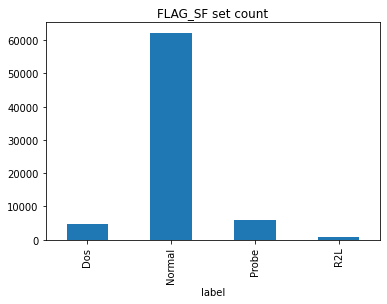

In [ ]:
ax = coded_df[coded_df['flag_SF']==1].groupby(['label']).srv_count.count().plot(kind='bar')
ax.set_title('FLAG_SF set count')

In [ ]:
coded_df.groupby('label').dst_host_serror_rate.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,28596.0,0.714166,0.447967,0.0,0.0,1.0,1.00,1.0
1,11019.0,0.042144,0.138641,0.0,0.0,0.0,0.01,1.0
2,982.0,0.017678,0.066574,0.0,0.0,0.0,0.00,1.0
3,65985.0,0.013963,0.092548,0.0,0.0,0.0,0.00,1.0


##Random Forest


In [ ]:
model = RandomForestClassifier(n_estimators=300)

In [ ]:
rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)
                     ])


In [ ]:
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['count', 'srv_count',
                                                   'serror_rate',
                                                   'srv_serror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_diff_srv_rate',
                                                   'dst_host_same_src_port_rate',
                                      

In [ ]:
preds = rf_clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      6260
           1       0.87      0.81      0.84      1723
           2       0.99      0.10      0.18      2112
           3       0.73      0.97      0.84      9652

    accuracy                           0.81     19747
   macro avg       0.89      0.67      0.68     19747
weighted avg       0.85      0.81      0.78     19747



In [ ]:
preds = rf_clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      6260
           1       0.87      0.81      0.84      1723
           2       0.99      0.10      0.18      2112
           3       0.73      0.97      0.84      9652

    accuracy                           0.81     19747
   macro avg       0.89      0.67      0.68     19747
weighted avg       0.85      0.81      0.78     19747



In [ ]:
fea_imps_rf = rf_clf.steps[1][1].feature_importances_
fea_imps_rf

array([5.03649800e-02, 2.83425154e-02, 3.60136712e-02, 1.93887017e-02,
       4.68704840e-02, 5.36296576e-02, 4.55660721e-03, 1.91434779e-02,
       3.64679681e-02, 4.10218055e-02, 3.82751611e-02, 3.40879259e-02,
       2.29246906e-02, 5.04343104e-02, 3.91965688e-02, 2.67571833e-02,
       1.15121764e-02, 4.79011979e-03, 5.16385942e-05, 1.50649362e-04,
       3.29000274e-05, 2.40811450e-03, 2.06913550e-02, 1.65630458e-02,
       3.10481539e-04, 1.99866174e-03, 5.69385316e-03, 1.25588625e-02,
       2.34214039e-03, 2.65219582e-02, 7.90022065e-04, 6.37617861e-04,
       5.71760139e-05, 2.02796309e-05, 3.54140414e-03, 9.97709462e-04,
       2.55527847e-04, 6.85212052e-03, 5.53038384e-02, 2.73522092e-04,
       2.56493789e-05, 1.95574445e-05, 3.74258689e-02, 5.76989229e-04,
       1.38817325e-01, 1.01303726e-01])

In [ ]:
pd.Series(fea_imps_rf, index=cols).sort_values(ascending=False).to_csv('rf_features.csv')

## One vs Rest

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
model = OneVsRestClassifier(DecisionTreeClassifier(),n_jobs = -1)

In [ ]:
onev = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)
                     ])

In [ ]:
onev.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['count', 'srv_count',
                                                   'serror_rate',
                                                   'srv_serror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_diff_srv_rate',
                                                   'dst_host_same_src_port_rate',
                                      

In [ ]:
preds = onev.predict(X_test)
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.70      0.98      0.81      4492
           1       0.82      0.85      0.83      1652
           2       0.06      0.76      0.11       168
           3       0.97      0.70      0.81     13435

    accuracy                           0.78     19747
   macro avg       0.64      0.82      0.64     19747
weighted avg       0.89      0.78      0.81     19747



In [ ]:
cols = pd.get_dummies(X_train).columns.to_list()

In [ ]:
ovr_imps = pd.DataFrame({i:j.feature_importances_ for i,j in enumerate(onev.steps[1][1].estimators_)},index=cols)

In [ ]:
ovr_imps.sort_values(by=0, ascending=False)

,0,1,2,3
dst_host_serror_rate,0.626654,0.000102,3.914083e-02,0.002515
service_domain_u,0.103884,0.000014,0.000000e+00,0.093938
diff_srv_rate,0.078984,0.002570,0.000000e+00,0.001476
same_srv_rate,0.073759,0.002034,0.000000e+00,0.000139
flag_SF,0.040819,0.284453,1.360439e-01,0.712231
srv_count,0.021228,0.000442,2.412798e-03,0.000081
service_ftp,0.017189,0.000000,0.000000e+00,0.064859
dst_host_same_src_port_rate,0.008988,0.006876,2.970578e-01,0.003630
service_http,0.008713,0.038382,0.000000e+00,0.001862
flag_S2,0.005459,0.000316,6.851998e-04,0.000159


In [ ]:
ovr_imps.sort_values(by=1,ascending=False)

,0,1,2,3
dst_host_diff_srv_rate,0.001042,0.309617,1.258930e-02,0.015247
service_courier,0.000000,0.301389,0.000000e+00,0.000010
flag_SF,0.040819,0.284453,1.360439e-01,0.712231
service_http,0.008713,0.038382,0.000000e+00,0.001862
dst_host_same_srv_rate,0.000163,0.014195,5.647362e-03,0.034636
flag_RSTO,0.000233,0.009938,5.138998e-04,0.000633
service_uucp,0.000046,0.008939,1.025130e-03,0.000284
dst_host_same_src_port_rate,0.008988,0.006876,2.970578e-01,0.003630
flag_REJ,0.000000,0.003812,0.000000e+00,0.000000
protocol_type_icmp,0.001782,0.003421,0.000000e+00,0.000000


In [ ]:
ovr_imps.sort_values(by=2,ascending=False)

,0,1,2,3
dst_host_same_src_port_rate,0.008988,0.006876,2.970578e-01,0.003630
dst_host_srv_count,0.000046,0.000835,1.394255e-01,0.004442
flag_SH,0.000000,0.001281,1.363152e-01,0.030502
flag_SF,0.040819,0.284453,1.360439e-01,0.712231
dst_host_srv_diff_host_rate,0.000022,0.000093,1.124040e-01,0.004253
service_ecr_i,0.000000,0.000153,5.261916e-02,0.002979
service_finger,0.000000,0.000270,4.168889e-02,0.013299
dst_host_serror_rate,0.626654,0.000102,3.914083e-02,0.002515
dst_host_count,0.000580,0.002180,1.373741e-02,0.002821
dst_host_diff_srv_rate,0.001042,0.309617,1.258930e-02,0.015247


In [ ]:
ovr_imps.sort_values(by=3,ascending=False)

,0,1,2,3
flag_SF,0.040819,0.284453,1.360439e-01,0.712231
service_domain_u,0.103884,0.000014,0.000000e+00,0.093938
service_ftp,0.017189,0.000000,0.000000e+00,0.064859
dst_host_same_srv_rate,0.000163,0.014195,5.647362e-03,0.034636
flag_SH,0.000000,0.001281,1.363152e-01,0.030502
dst_host_diff_srv_rate,0.001042,0.309617,1.258930e-02,0.015247
service_finger,0.000000,0.000270,4.168889e-02,0.013299
dst_host_srv_count,0.000046,0.000835,1.394255e-01,0.004442
dst_host_srv_diff_host_rate,0.000022,0.000093,1.124040e-01,0.004253
count,0.003233,0.001412,6.867570e-04,0.003859


In [ ]:
label_map = { 0:'Dos' , 1:'Probe', 2:'R2L' , 3:'Normal'} 

In [ ]:
coded_df.label = coded_df.label.apply(lambda x : label_map[x])

Text(0.5, 1.0, 'dst_host_serror_rate mean')

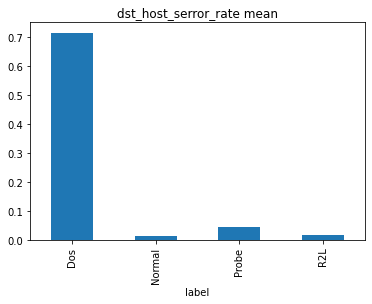

In [ ]:
ax = coded_df.groupby('label').dst_host_serror_rate.mean().plot(kind='bar')
ax.set_title('dst_host_serror_rate mean')

Text(0.5, 1.0, 'dst_host_diff_srv_rate mean')

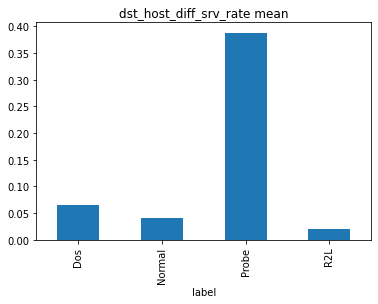

In [ ]:
ax = coded_df.groupby('label').dst_host_diff_srv_rate.mean().plot(kind='bar')
ax.set_title('dst_host_diff_srv_rate mean')

Text(0.5, 1.0, 'dst_host_same_src_port_rate mean')

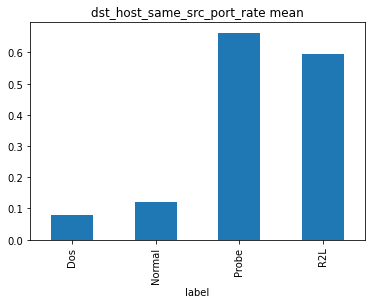

In [ ]:
ax = coded_df.groupby('label').dst_host_same_src_port_rate.mean().plot(kind='bar')
ax.set_title('dst_host_same_src_port_rate mean')

Text(0.5, 1.0, 'dst_host_srv_count median')

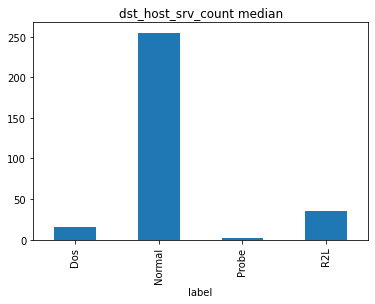

In [ ]:
ax = coded_df.groupby('label').dst_host_srv_count.median().plot(kind='bar')
ax.set_title('dst_host_srv_count median')

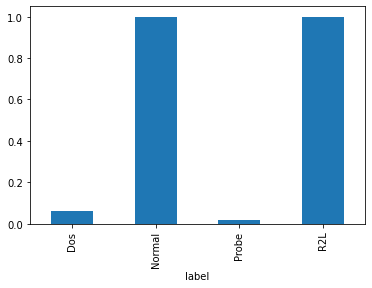

In [ ]:
coded_df.groupby('label').dst_host_same_srv_rate.median().plot(kind='bar')

## AE

In [ ]:
from keras.layers import Input
from keras.models import Model

In [ ]:
input_dim = tranformed_train.shape[1]
encoding_dim = 50


input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu")(input_layer)           
output_layer = Dense(input_dim, activation='softmax')(encoder)

In [ ]:
ae_output = Dense(4, activation='softmax')(encoder)

In [ ]:
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# defining loss function, optimizer, metrics and then compiling model
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 101)]             0         
                                                                 
 dense_31 (Dense)            (None, 50)                5100      
                                                                 
 dense_32 (Dense)            (None, 101)               5151      
                                                                 
Total params: 10,251
Trainable params: 10,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(tranformed_train, tranformed_train, epochs=6, batch_size=500, validation_data=(transformed_test, transformed_test)).history

Epoch 1/6
252/252 [==============================] - 2s 6ms/step - loss: 501528395776.0000 - accuracy: 0.5616 - val_loss: 2225131264.0000 - val_accuracy: 0.7373
Epoch 2/6
252/252 [==============================] - 1s 5ms/step - loss: 501528068096.0000 - accuracy: 0.6607 - val_loss: 2225131264.0000 - val_accuracy: 0.7205
Epoch 3/6
252/252 [==============================] - 1s 5ms/step - loss: 501528264704.0000 - accuracy: 0.6734 - val_loss: 2225131264.0000 - val_accuracy: 0.7499
Epoch 4/6
252/252 [==============================] - 1s 5ms/step - loss: 501528264704.0000 - accuracy: 0.6674 - val_loss: 2225131264.0000 - val_accuracy: 0.7507
Epoch 5/6
252/252 [==============================] - 1s 5ms/step - loss: 501528363008.0000 - accuracy: 0.6581 - val_loss: 2225131264.0000 - val_accuracy: 0.7462
Epoch 6/6
252/252 [==============================] - 1s 5ms/step - loss: 501528330240.0000 - accuracy: 0.6397 - val_loss: 2225131264.0000 - val_accuracy: 0.7426


In [ ]:
train_predictions = autoencoder.predict(tranformed_train)
mse = np.mean(np.power(transformed_test - predictions, 2), axis=1)
#error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
#error_df = error_df.reset_index()
#error_df

In [ ]:
test_predictions = autoencoder.predict(transformed_test)

In [ ]:
i_dim = train_predictions.shape[1]

ae_classifier = Sequential()
#input layer
ae_classifier.add(encoder)
#hidden layer with 50 neurons
#doutput layer
ae_classifier.add(Dense(4, activation='sigmoid'))

TypeError: ignored

In [ ]:
# creating model with input, encoding, decoding, output layers
ae_classifier = Model(inputs=input_layer, outputs=ae_output)

# defining loss function, optimizer, metrics and then compiling model
ae_classifier.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
ae_classifier.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 101)]             0         
                                                                 
 dense_31 (Dense)            (None, 50)                5100      
                                                                 
 dense_33 (Dense)            (None, 4)                 204       
                                                                 
Total params: 5,304
Trainable params: 5,304
Non-trainable params: 0
_________________________________________________________________


In [ ]:
his = ae_classifier.fit(train_predictions, y_train, epochs=25, batch_size=500).history

Epoch 1/25
252/252 [==============================] - 1s 4ms/step - loss: 0.7074 - accuracy: 0.7798
Epoch 2/25
252/252 [==============================] - 1s 4ms/step - loss: 0.3743 - accuracy: 0.8725
Epoch 3/25
252/252 [==============================] - 1s 4ms/step - loss: 0.3422 - accuracy: 0.8830
Epoch 4/25
252/252 [==============================] - 1s 4ms/step - loss: 0.3302 - accuracy: 0.8877
Epoch 5/25
252/252 [==============================] - 1s 4ms/step - loss: 0.3248 - accuracy: 0.8880
Epoch 6/25
252/252 [==============================] - 1s 4ms/step - loss: 0.3212 - accuracy: 0.8885
Epoch 7/25
252/252 [==============================] - 1s 4ms/step - loss: 0.3182 - accuracy: 0.8885
Epoch 8/25
252/252 [==============================] - 1s 4ms/step - loss: 0.3156 - accuracy: 0.8885
Epoch 9/25
252/252 [==============================] - 1s 4ms/step - loss: 0.3134 - accuracy: 0.8886
Epoch 10/25
252/252 [==============================] - 1s 4ms/step - loss: 0.3113 - accuracy: 0.8888

In [ ]:
preds = ae_classifier.predict(transformed_test).argmax(axis=1)

print(classification_report(preds, y_test.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.39      0.80      0.52      3617
           1       0.36      0.28      0.32      3145
           2       0.00      0.00      0.00         0
           3       0.98      0.60      0.75     15715

    accuracy                           0.59     22477
   macro avg       0.43      0.42      0.40     22477
weighted avg       0.80      0.59      0.65     22477



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
